In [1]:
import numpy as np
import os 
import time

from scipy.signal import savgol_filter
from scipy.stats import linregress

# My custom library of photoelastic tools
import sys
sys.path.append('/eno/jdfeathe/pepe/')
#sys.path.append('/home/jack//workspaces/jupyter-workspace/pepe/')

from pepe.auto import Trial
from pepe.analysis import derivative, determineLinearRegions
from pepe.visualize import genColors

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 140
plt.rcParams["font.size"] = 13

In [2]:
syntheticFolder = '../'
#syntheticFolder = '/eno/jdfeathe/DATA/SpaceJam_Synthetic/'
dataKey = '2022-04-29_'
radius = 160

fileList = os.listdir(syntheticFolder)

fileList = np.sort([f for f in fileList if dataKey in f])
#fileList = fileList[:3]

speedArr = [float(f.split('_')[1]) for f in fileList]
stiffnessArr = [f.split('_')[2] for f in fileList]

fileList

array(['2022-04-29_100_MHS_Gap1_0_Synthetic',
       '2022-04-29_100_MHS_Gap1_1_Synthetic',
       '2022-04-29_100_MHS_Gap1_2_Synthetic',
       '2022-04-29_100_MHS_Gap1_3_Synthetic',
       '2022-04-29_100_MHS_Gap1_4_Synthetic',
       '2022-04-29_100_MHS_Gap1_5_Synthetic',
       '2022-04-29_100_MHS_Gap1_NoAir_0_Synthetic',
       '2022-04-29_100_MHS_Gap1_NoAir_1_Synthetic',
       '2022-04-29_100_MHS_Gap1_NoAir_2_Synthetic',
       '2022-04-29_100_MHS_Gap1_NoAir_3_Synthetic',
       '2022-04-29_100_MHS_Gap2_0_Synthetic',
       '2022-04-29_100_MHS_Gap2_1_Synthetic',
       '2022-04-29_100_MHS_Gap2_2_Synthetic',
       '2022-04-29_100_MHS_Gap2_3_Synthetic',
       '2022-04-29_100_MHS_Gap2_4_Synthetic',
       '2022-04-29_100_MHS_Gap2_5_Synthetic',
       '2022-04-29_100_MHS_Gap3_0_Synthetic',
       '2022-04-29_100_MHS_Gap3_1_Synthetic',
       '2022-04-29_100_MHS_Gap3_2_Synthetic',
       '2022-04-29_100_MHS_Gap3_3_Synthetic',
       '2022-04-29_100_MHS_Gap3_4_Synthetic',
       '20

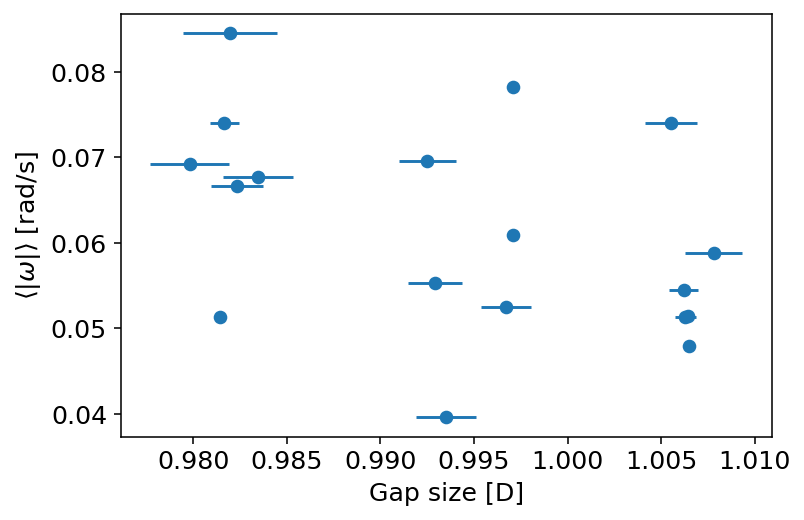

In [3]:
gapSizeArr = []
gapSizeSTDArr = []
rotationArr = []
rotationSTDArr = []
angularVelocityArr = []
angularVelocitySTDArr = []

for i in range(len(fileList)):
    
    if 'NoAir' in fileList[i]:
        continue
    
    trial = Trial(syntheticFolder + fileList[i])
    
    # Find the gap size
    topIndex = trial.particleNear([200, 600])
    bottomIndex = trial.particleNear([800, 600])
    separation = np.sqrt(np.sum((trial.centerArr[topIndex] - trial.centerArr[bottomIndex]).astype(np.float64)**2, axis=-1)) - 2*radius
    #print(separation)
    separation = separation / (2*radius)
    
    # Find the rotation of the central particle
    particleIndex = trial.particleNear([500, 500])
    #forceIndex = np.argmin(np.abs(trial.averageForcePositions(particleIndex) - np.pi/2))

    # Sum the rotation
    dTheta = np.append(np.zeros(1), trial.angleArr[particleIndex][:-1] - trial.angleArr[particleIndex][1:])
    totalRotation = np.sum(np.abs(dTheta))
    
    # Find the average angular velocity
    smoothedAngle = savgol_filter(trial.angleArr[particleIndex], 11, 3)
    omegaArr = np.abs(derivative(smoothedAngle, 1/70))
    
    gapSizeArr.append(np.mean(separation[:30]))
    gapSizeSTDArr.append(np.std(separation[:30]))
    rotationArr.append(np.mean(omegaArr))
    rotationSTDArr.append(np.std(omegaArr))

plt.errorbar(x=gapSizeArr, y=rotationArr, xerr=gapSizeSTDArr, fmt='o')
plt.xlabel('Gap size [D]')
plt.ylabel(r'$\langle | \omega | \rangle$ [rad/s]')
plt.show()

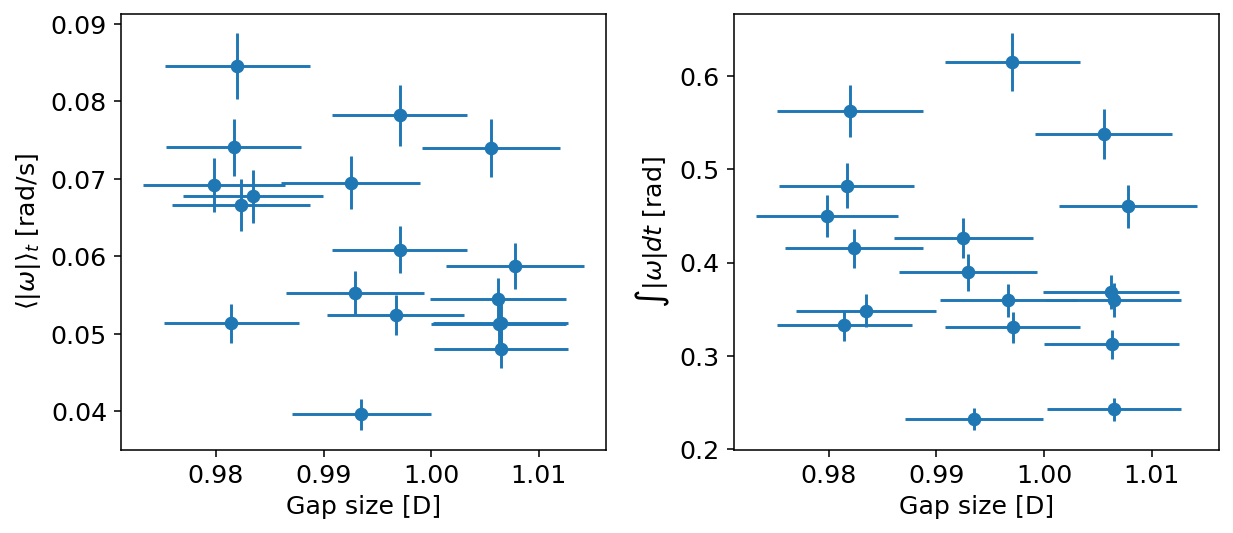

In [9]:
gapSizeArr = []
gapSizeSTDArr = []
rotationArr = []
rotationSTDArr = []
angularVelocityArr = []
angularVelocitySTDArr = []

for i in range(len(fileList)):
    
    if 'NoAir' in fileList[i]:
        continue
    
    trial = Trial(syntheticFolder + fileList[i])
    
    # Find the gap size
    topIndex = trial.particleNear([200, 600])
    bottomIndex = trial.particleNear([800, 600])
    separation = np.sqrt(np.sum((trial.centerArr[topIndex] - trial.centerArr[bottomIndex]).astype(np.float64)**2, axis=-1)) - 2*radius
    #print(separation)
    separation = separation / (2*radius)
    
    # Find the rotation of the central particle
    particleIndex = trial.particleNear([500, 500])
    #forceIndex = np.argmin(np.abs(trial.averageForcePositions(particleIndex) - np.pi/2))

    # Sum the rotation
    dTheta = np.append(np.zeros(1), trial.angleArr[particleIndex][:-1] - trial.angleArr[particleIndex][1:])
    totalRotation = np.sum(np.abs(dTheta))
    
    # Find the average angular velocity
    smoothedAngle = savgol_filter(trial.angleArr[particleIndex], 11, 3)
    omegaArr = np.abs(derivative(smoothedAngle, 1/70))
    
    # We first identify which regions have some linear change in the angle
    linearRegions, slopes, intercepts = determineLinearRegions(smoothedAngle, minR2=.90)
#     plt.plot(smoothedAngle)
#     if len(linearRegions) > 0:
#         colors = genColors(len(linearRegions))
#         for i in range(len(linearRegions)):
#             plt.axvline(linearRegions[i][0], c=colors[i], linestyle='--')
#             plt.axvline(linearRegions[i][1]-1, c=colors[i], linestyle='--')

#     plt.show()
    
    # Now calculate the approximate amount the particle rotated during each
    # rotation period
    totalRotation = np.sum([np.abs(slopes[j] * (linearRegions[j][1] - linearRegions[j][0])) for j in range(len(linearRegions))])
    
    gapSizeArr.append(np.mean(separation[:30]))
    gapSizeSTDArr.append(np.std(separation[:30]))
    rotationArr.append(totalRotation)
    angularVelocityArr.append(np.mean(omegaArr))
    #rotationSTDArr.append(np.std(omegaArr))

# Add in systematic error from locating particles
gapSizeSTDArr = np.sqrt(np.array(gapSizeSTDArr)**2 + (2/(2*radius))**2)

# Just systematic for this one, since we don't really have statistics
# Just assume 5% error (sounds reasonable...)
angularSTDArr = np.array(rotationArr) * .05
angularVelocitySTDArr = np.array(angularVelocityArr) * .05

fig, ax = plt.subplots(1, 2, figsize=(9,4))

ax[0].errorbar(x=gapSizeArr, y=angularVelocityArr, xerr=gapSizeSTDArr, yerr=angularVelocitySTDArr, fmt='o')
ax[0].set_xlabel('Gap size [D]')
ax[0].set_ylabel(r'$\langle | \omega | \rangle_t$ [rad/s]')

ax[1].errorbar(x=gapSizeArr, y=rotationArr, xerr=gapSizeSTDArr, yerr=angularSTDArr, fmt='o')
ax[1].set_xlabel('Gap size [D]')
ax[1].set_ylabel(r'$\int | \omega | dt$ [rad]')

fig.tight_layout()
plt.show()

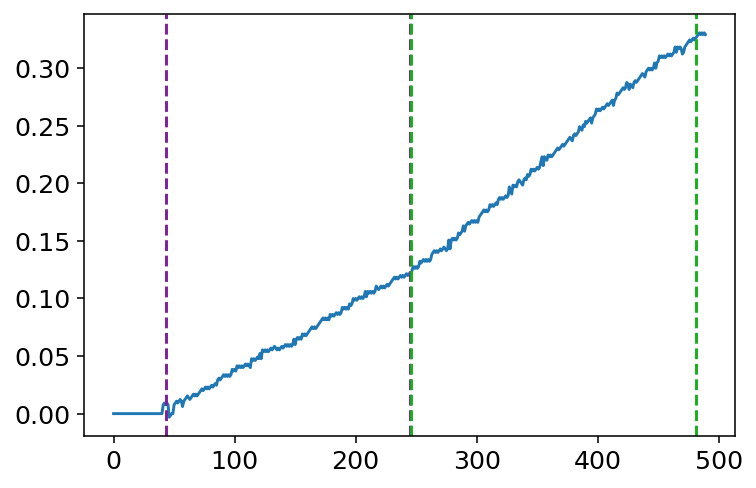

In [134]:
testData = trial.angleArr[particleIndex]
plt.plot(testData)

linearRegions, slopes, intercepts = determineLinearRegions(testData)
if len(linearRegions) > 0:
    colors = genColors(len(linearRegions))
    for i in range(len(linearRegions)):
        plt.axvline(linearRegions[i][0], c=colors[i], linestyle='--')
        plt.axvline(linearRegions[i][1]-1, c=colors[i], linestyle='--')

plt.show()